In [14]:
import numpy as np

samples = np.random.randint(0, 256,(10, 3, 28, 28)) # N x C x H x W
samples.shape

(10, 3, 28, 28)

In [22]:
import numpy as np
from collections import OrderedDict

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#def softmax(x):
#        c = np.max(x)
#        exp_x = np.exp(x - c)
#        sum_exp_x = np.sum(exp_x)
#        y = exp_x / sum_exp_x
#        
#        return y
 
def softmax(x):
    if x.ndim == 2:
        c = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    else:
        c = np.max(x)
        exp_x = np.exp(x - c)
        return exp_x / np.sum(exp_x)
       
def CEE(y, t):
    if y.ndim == 1:
        y = y.reshape(1, -1)
        t = t.reshape(1)
    
    if t.ndim == 1:
        return -np.sum(np.log(y[np.arange(len(t)), t] + 1e-7)) / len(t)
    else:
        return -np.sum(t * np.log(y + 1e-7)) / y.shape[0]

def gradient(f, x):
    h = 0.0001

    shape = x.shape
    x_flatten = x.reshape(-1)
    size = len(x_flatten)

    grad = np.zeros_like(x_flatten)

    for i in range(size):
        x_val = x_flatten[i]

        x_flatten[i] = x_val + h
        fxh1 = f(x_flatten.reshape(shape))

        x_flatten[i] = x_val - h
        fxh2 = f(x_flatten.reshape(shape))

        grad[i] = (fxh1 - fxh2) / (2*h)

        x_flatten[i] = x_val
        
    return grad.reshape(shape)

class ReLU:
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        self.x = x
        return (x > 0)*x
    
    def backward(self, dz):
        return dz*(self.x > 0).astype(int)
    
class Sigmoid:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x):
        self.x = x
        self.y = 1 / (1 + np.exp(-self.x))
        return self.y
    
    def backward(self, dz):
        return dz * self.y *(1 - self.y)
    
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.X = None 
        
    def forward(self, X):
        self.X = X        
        return np.dot(X, self.W) + self.b
    
    def backward(self, dz):
        grads = {}
        grads["W"] = np.dot(self.X.T, dz)
        grads["X"] = np.dot(dz, self.W.T)
        grads["b"] = np.sum(dz, axis=0)
        
        return grads

class Softmax_with_Loss:
    def __init__(self):
        self.y = None
        self.t = None
        
    def forward(self, X, t):
        self.y = softmax(X)
        self.t = t
        loss = CEE(self.y, self.t)
        
        return loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        
        if self.t.ndim == 1:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
        else:
            dx = (self.y - self.t)
        
        return dx / batch_size

In [45]:
import numpy as np

def padding(input_data, pad=0):
    _, _, h, w = input_data.shape
    padded_data = []
    
    for data in input_data:
        temp_data = []
        for c_data in data:
            padded_c_data = np.zeros((h + 2*pad, w + 2*pad))
            padded_c_data[pad:pad+h, pad:pad+w] = c_data
            temp_data.append(list(padded_c_data))

        padded_data.append(temp_data)

    return np.array(padded_data)

In [46]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    input_data = padding(input_data, pad=pad)
    
    data_h = input_data.shape[2]
    data_w = input_data.shape[3]
    
    cols = []
    
    end_w_index = data_w - filter_w
    end_h_index = data_h - filter_h
    
    for data in input_data:
        for h_index in range(0, end_h_index+1, stride):
            for w_index in range(0, end_w_index+1, stride):
                feature_map = data[:, h_index:h_index+filter_h, w_index:w_index+filter_w]
                cols.append(list(feature_map.reshape(-1,)))

    return np.array(cols)

def col2im(cols, input_shape, filter_h, filter_w, stride=1, pad=0):
    data_n, data_c, data_h, data_w = input_shape
    output_h = int((data_h + 2 * pad - filter_h) // stride + 1)
    output_w = int((data_w + 2 * pad - filter_w) // stride + 1)

    img = np.zeros((data_n, data_c, data_h + 2 * pad, data_w + 2 * pad))

    cols_reshaped = cols.reshape(data_n, output_h, output_w, data_c, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    for h_index in range(filter_h):
        h_end = h_index + stride * output_h
        for w_index in range(filter_w):
            w_end = w_index + stride * output_w
            img[:, :, h_index:h_end:stride, w_index:w_end:stride] += cols_reshaped[:, :, h_index, w_index, :, :]

    return img[:, :, pad:pad + data_h, pad:pad + data_w]

In [47]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        self.grads = {}
        
    def forward(self, x):
        self.x = x
        filter_num, c, filter_h, filter_w = self.W.shape
        data_num, _, h, w = x.shape
        
        output_h = int((h + 2*self.pad - filter_h) / self.stride + 1)
        output_w = int((w + 2*self.pad - filter_w) / self.stride + 1)
        
        self.cols_img_data = im2col(x, filter_h, filter_w, stride=self.stride, pad=self.pad)
        #print(f"shape of cols_img : {self.cols_img_data.shape}")
        self.cols_W = self.W.reshape(filter_num, -1)
        #print(f"shape of cols_W : {cols_W.T.shape}")
        output = np.dot(self.cols_img_data, self.cols_W.T) + self.b
        output = output.reshape(data_num, output_h, output_w, filter_num).transpose(0, 3, 1, 2)
        #print(f"shape of output : {output.shape}")
        
        return output
    
    def backward(self, dout):
        filter_num, c, filter_h, filter_w = self.W.shape

        dout = dout.transpose(0, 2, 3, 1).reshape(-1, filter_num)            # (N*out_h*out_w, FN)

        self.grads["b"] = np.sum(dout, axis=0)
        self.grads["W"] = np.dot(self.cols_img_data.T, dout).transpose(1, 0).reshape(filter_num, c, filter_h, filter_w)                               # (C*FH*FW, FN)
        # input gradient
        dcols_img_data = np.dot(dout, self.cols_W)                            # (N*out_h*out_w, C*FH*FW)
        self.grads["X"] = col2im(dcols_img_data, self.x.shape, filter_h, filter_w, self.stride, self.pad)

        return self.grads

In [53]:
import numpy as np

class Pooling:
    def __init__(self, pooling_h=2, pooling_w=2, stride=2, pad=0):
        self.pooling_h = pooling_h
        self.pooling_w = pooling_w
        self.stride = stride
        self.pad = pad
        self.output_h = None
        self.output_w = None
        
    def forward(self, x):
        data_num, c, h, w = x.shape
        self.x = x        
        self.output_h = int((h + 2*self.pad - self.pooling_h) / self.stride + 1)
        self.output_w = int((w + 2*self.pad - self.pooling_w) / self.stride + 1)
        
        self.cols_data = im2col(x, self.pooling_h, self.pooling_w, stride=self.stride, pad=self.pad) # N*OH*OW x C*PH*PW
        cols = self.cols_data.reshape(-1, self.pooling_h*self.pooling_w) # N*OH*OW x C*PH*PW -> N*OH*OW*C x PH*PW
        
        self.arg_max = np.argmax(cols, axis=1)
        pooling_res_flatten = np.max(cols, axis=1)
        pooling_res = pooling_res_flatten.reshape(data_num, self.output_h, self.output_w, c).transpose(0, 3, 1, 2) # N x OH x OW x C -> N x C x OH x OW
        
        return pooling_res # N x C x OH x OW
    
    def backward(self, dout):
        data_num, c, h, w = self.x.shape
        
        dpolling_res_flatten = dout.transpose(0, 2, 3, 1).reshape(-1)

        dcols = np.zeros((data_num * c * self.output_h * self.output_w, self.pooling_h * self.pooling_w))
        dcols[np.arange(len(self.arg_max)), self.arg_max] = dpolling_res_flatten

        dcols_data = dcols.reshape(self.cols_data.shape[0], -1)
        return col2im(dcols_data, self.x.shape, self.pooling_h, self.pooling_w, self.stride, self.pad)

In [20]:
import numpy as np
from collections import OrderedDict

def padding(input_data, pad=0):
    _, _, h, w = input_data.shape
    padded_data = []
    
    for data in input_data:
        temp_data = []
        for c_data in data:
            padded_c_data = np.zeros((h + 2*pad, w + 2*pad))
            padded_c_data[pad:pad+h, pad:pad+w] = c_data
            temp_data.append(list(padded_c_data))

        padded_data.append(temp_data)

    return np.array(padded_data)

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    input_data = padding(input_data, pad=pad)
    
    data_h = input_data.shape[2]
    data_w = input_data.shape[3]
    
    cols = []
    
    end_w_index = data_w - filter_w
    end_h_index = data_h - filter_h
    
    for data in input_data:
        for h_index in range(0, end_h_index+1, stride):
            for w_index in range(0, end_w_index+1, stride):
                feature_map = data[:, h_index:h_index+filter_h, w_index:w_index+filter_w]
                cols.append(list(feature_map.reshape(-1,)))

    return np.array(cols)

def col2im(cols, input_shape, filter_h, filter_w, stride=1, pad=0):
    data_n, data_c, data_h, data_w = input_shape
    output_h = int((data_h + 2 * pad - filter_h) // stride + 1)
    output_w = int((data_w + 2 * pad - filter_w) // stride + 1)

    img = np.zeros((data_n, data_c, data_h + 2 * pad, data_w + 2 * pad))

    cols_reshaped = cols.reshape(data_n, output_h, output_w, data_c, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    for h_index in range(filter_h):
        h_end = h_index + stride * output_h
        for w_index in range(filter_w):
            w_end = w_index + stride * output_w
            img[:, :, h_index:h_end:stride, w_index:w_end:stride] += cols_reshaped[:, :, h_index, w_index, :, :]

    return img[:, :, pad:pad + data_h, pad:pad + data_w]

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        self.grads = {}
        
    def forward(self, x):
        self.x = x
        filter_num, c, filter_h, filter_w = self.W.shape
        data_num, _, h, w = x.shape
        
        output_h = int((h + 2*self.pad - filter_h) / self.stride + 1)
        output_w = int((w + 2*self.pad - filter_w) / self.stride + 1)
        
        self.cols_img_data = im2col(x, filter_h, filter_w, stride=self.stride, pad=self.pad)
        #print(f"shape of cols_img : {self.cols_img_data.shape}")
        self.cols_W = self.W.reshape(filter_num, -1)
        #print(f"shape of cols_W : {cols_W.T.shape}")
        output = np.dot(self.cols_img_data, self.cols_W.T) + self.b
        output = output.reshape(data_num, output_h, output_w, filter_num).transpose(0, 3, 1, 2)
        #print(f"shape of output : {output.shape}")
        
        return output
    
    def backward(self, dout):
        filter_num, c, filter_h, filter_w = self.W.shape

        dout = dout.transpose(0, 2, 3, 1).reshape(-1, filter_num)            # (N*out_h*out_w, FN)

        self.grads["b"] = np.sum(dout, axis=0)
        self.grads["W"] = np.dot(self.cols_img_data.T, dout).transpose(1, 0).reshape(filter_num, c, filter_h, filter_w)                               # (C*FH*FW, FN)
        # input gradient
        dcols_img_data = np.dot(dout, self.cols_W)                            # (N*out_h*out_w, C*FH*FW)
        self.grads["X"] = col2im(dcols_img_data, self.x.shape, filter_h, filter_w, self.stride, self.pad)

        return self.grads
class Pooling:
    def __init__(self, pooling_h=2, pooling_w=2, stride=2, pad=0):
        self.pooling_h = pooling_h
        self.pooling_w = pooling_w
        self.stride = stride
        self.pad = pad
        self.output_h = None
        self.output_w = None
        
    def forward(self, x):
        data_num, c, h, w = x.shape
        self.x = x        
        self.output_h = int((h + 2*self.pad - self.pooling_h) / self.stride + 1)
        self.output_w = int((w + 2*self.pad - self.pooling_w) / self.stride + 1)
        
        self.cols_data = im2col(x, self.pooling_h, self.pooling_w, stride=self.stride, pad=self.pad) # N*OH*OW x C*PH*PW
        cols = self.cols_data.reshape(-1, self.pooling_h*self.pooling_w) # N*OH*OW x C*PH*PW -> N*OH*OW*C x PH*PW
        
        self.arg_max = np.argmax(cols, axis=1)
        pooling_res_flatten = np.max(cols, axis=1)
        pooling_res = pooling_res_flatten.reshape(data_num, self.output_h, self.output_w, c).transpose(0, 3, 1, 2) # N x OH x OW x C -> N x C x OH x OW
        
        return pooling_res # N x C x OH x OW
    
    def backward(self, dout):
        data_num, c, h, w = self.x.shape
        
        dpolling_res_flatten = dout.transpose(0, 2, 3, 1).reshape(-1)

        dcols = np.zeros((data_num * c * self.output_h * self.output_w, self.pooling_h * self.pooling_w))
        dcols[np.arange(len(self.arg_max)), self.arg_max] = dpolling_res_flatten

        dcols_data = dcols.reshape(self.cols_data.shape[0], -1)
        return col2im(dcols_data, self.x.shape, self.pooling_h, self.pooling_w, self.stride, self.pad)
    
class SimpleConvNet:
    def __init__(self, input_dim, conv_param, hidden_size=100, output_size=10, weight_init_std=0.001):
        self.data_c = input_dim[0]
        self.data_h = input_dim[1]
        self.data_w = input_dim[2]
        
        self.filter_num = conv_param["filter_num"]
        self.filter_h = conv_param["filter_size"]
        self.filter_w = conv_param["filter_size"]
        
        self.stride = conv_param["stride"]
        self.pad = conv_param["pad"]
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_init_std = weight_init_std
        
        self.conv_output_h = None
        self.conv_output_w = None
        
        self.pooling_output_h = None
        self.pooling_output_w = None
        
        self.params = {}
        self.layers = OrderedDict()
        
        # input : N x C x H x W
        # output : N x FN x OH x OW
        # OH = (H + 2*pad - filter_h)/stride + 1
        # OW = (W + 2*pad - filter_w)/stride + 1
        self.params["W1"] = np.random.randn(self.filter_num, self.data_c, self.filter_h, self.filter_w) * self.weight_init_std
        self.params["B1"] = np.zeros(self.filter_num)
        self.layers["Conv"] = Convolution(self.params["W1"], self.params["B1"], stride=self.stride, pad=self.pad)
        self.conv_output_h = int((self.data_h + 2*self.pad - self.filter_h)/self.stride + 1)
        self.conv_output_w = int((self.data_w + 2*self.pad - self.filter_w)/self.stride + 1)
        
        self.layers["ReLU1"] = ReLU()
        
        # input : N x FN x OH x OW
        # output : N x FN x Pooling_OH x Pooling_OW
        # Pooling_OH = (OH + 2*pad - pooling_h)/stride + 1 -> (OH - 2)/2 + 1 
        # Pooling_OW = (OW + 2*pad - pooling_h)/stride + 1
        pooling_h = 2
        pooling_w = 2
        pooling_stride = 2
        pooling_pad = 0
        self.layers["Pooling"] = Pooling(pooling_h, pooling_w, pooling_stride, pooling_pad)
        self.pooling_output_h = int((self.conv_output_h + 2*pooling_pad - pooling_h)/pooling_stride + 1)
        self.pooling_output_w = int((self.conv_output_w + 2*pooling_pad - pooling_w)/pooling_stride + 1)
        
        # input : N x FN x OH x OW
        # output : N x FN x Pooling_OH x Pooling_OW
        # OH = (OH + 2*pad - pooling_h)/stride + 1
        # OW = (OW + 2*pad - pooling_h)/stride + 1
        feature_size = self.filter_num*self.pooling_output_h*self.pooling_output_w
        self.params["W2"] = np.random.randn(feature_size, self.hidden_size) * self.weight_init_std
        self.params["B2"] = np.zeros(self.hidden_size)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["B2"])
        self.layers["ReLU2"] = ReLU()
        
        
        self.params["W3"] = np.random.randn(self.hidden_size, self.output_size) * self.weight_init_std
        self.params["B3"] = np.zeros(self.output_size)
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["B3"])
        
        self.last_layer = Softmax_with_Loss()
    
    def predict(self, x):
        data_n = x.shape[0]
        f = self.layers["Conv"].forward(x)
        f = self.layers["ReLU1"].forward(f)
        f = self.layers["Pooling"].forward(f)
        f = f.reshape(data_n, -1)
        h = self.layers["Affine1"].forward(f)
        h = self.layers["ReLU2"].forward(h)
        y = self.layers["Affine2"].forward(h)
        
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        logit = self.predict(x)  # 예측 결과 로짓 (N, 10)
        y = np.argmax(logit, axis=1)

        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
    
        return accuracy
    
    def gradient(self, x, t):
        grads = {}
    
        self.loss(x, t)  # 내부적으로 forward 수행됨
    
        # Backward from Softmax
        dout = self.last_layer.backward()
    
        # Affine2 backward
        temp_grads = self.layers["Affine2"].backward(dout)
        grads["W3"] = temp_grads["W"]
        grads["B3"] = temp_grads["b"]
        dout = temp_grads["X"]
    
        # ReLU2 backward
        dout = self.layers["ReLU2"].backward(dout)
    
        # Affine1 backward
        temp_grads = self.layers["Affine1"].backward(dout)
        grads["W2"] = temp_grads["W"]
        grads["B2"] = temp_grads["b"]
        dout = temp_grads["X"]
    
        # Reshape to N x C x H x W before Pooling backward
        dout = dout.reshape(-1, self.filter_num, self.pooling_output_h, self.pooling_output_w)
    
        # Pooling backward
        dout = self.layers["Pooling"].backward(dout)
    
        # ReLU1 backward
        dout = self.layers["ReLU1"].backward(dout)
    
        # Conv backward
        temp_grads = self.layers["Conv"].backward(dout)
        grads["W1"] = temp_grads["W"]
        grads["B1"] = temp_grads["b"]
    
        return grads

In [28]:
from math import ceil
from dataset.mnist import load_mnist
from optimizer import Adam

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

train_size = x_train.shape[0]
batch_size = 100
lr = 0.01
iter_per_epoch = ceil(train_size / batch_size)
epochs_num = 20
evaluate_sample_num_per_epoch = 1000

def shuffle_data(x, t):
    idx = np.random.permutation(x.shape[0])  # 무작위 인덱스 생성
    return x[idx], t[idx]

#def shuffle_data(x, t):
#    x_dim = x.shape[1]
#    xt_concat = np.concatenate([x, t], axis=1)
#    
#    np.random.shuffle(xt_concat)
#    
#    x_shuffled = xt_concat[:, :x_dim]
#    t_shuffled = xt_concat[:, x_dim:]
#    
#    return x_shuffled, t_shuffled

optimizer = Adam(lr)
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

train_accuracy_list = []
test_accuracy_list = []

train_accuracy = network.accuracy(x_train[:evaluate_sample_num_per_epoch], t_train[:evaluate_sample_num_per_epoch])
train_accuracy_list.append(train_accuracy)
test_accuracy = network.accuracy(x_test[:evaluate_sample_num_per_epoch], t_test[:evaluate_sample_num_per_epoch])
test_accuracy_list.append(test_accuracy)

for epoch in range(epochs_num):
    x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
    
    offset = 0
    for i in range(iter_per_epoch):
        x_batch = x_train_shuffled[offset:offset+batch_size]
        t_batch = t_train_shuffled[offset:offset+batch_size]
        
        grads = network.gradient(x_batch, t_batch)
        if i % 10 == 0:
            loss = network.loss(x_batch, t_batch)
            print(f"| epoch : {epoch} | iteration : {i}/{iter_per_epoch} | train loss : {loss} |")
        optimizer.update(network.params, grads)

        offset += batch_size
    
    x_train_eval, t_train_eval = shuffle_data(x_train, t_train)
    x_test_eval, t_test_eval = shuffle_data(x_test, t_test)
    
    train_accuracy = network.accuracy(x_train_eval[:evaluate_sample_num_per_epoch], t_train_eval[:evaluate_sample_num_per_epoch])
    test_accuracy = network.accuracy(x_test_eval[:evaluate_sample_num_per_epoch], t_test_eval[:evaluate_sample_num_per_epoch])
    
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    print(f"| epoch {epoch} | train_accuracy : {train_accuracy:.4f} | test_accuracy : {test_accuracy:.4f} |")

| epoch : 0 | iteration : 0/600 | train loss : 2.302479648966259
| epoch : 0 | iteration : 10/600 | train loss : 0.8510506325918848
| epoch : 0 | iteration : 20/600 | train loss : 0.48679326733747624
| epoch : 0 | iteration : 30/600 | train loss : 0.1991722295205026
| epoch : 0 | iteration : 40/600 | train loss : 0.28200213583028505
| epoch : 0 | iteration : 50/600 | train loss : 0.2050880366224326
| epoch : 0 | iteration : 60/600 | train loss : 0.3101569607678131
| epoch : 0 | iteration : 70/600 | train loss : 0.2438750658054127
| epoch : 0 | iteration : 80/600 | train loss : 0.14048609547609214
| epoch : 0 | iteration : 90/600 | train loss : 0.10229013545419852
| epoch : 0 | iteration : 100/600 | train loss : 0.1463477665264461
| epoch : 0 | iteration : 110/600 | train loss : 0.16255681323457863
| epoch : 0 | iteration : 120/600 | train loss : 0.1007419600387173
| epoch : 0 | iteration : 130/600 | train loss : 0.25751932041998754
| epoch : 0 | iteration : 140/600 | train loss : 0.114

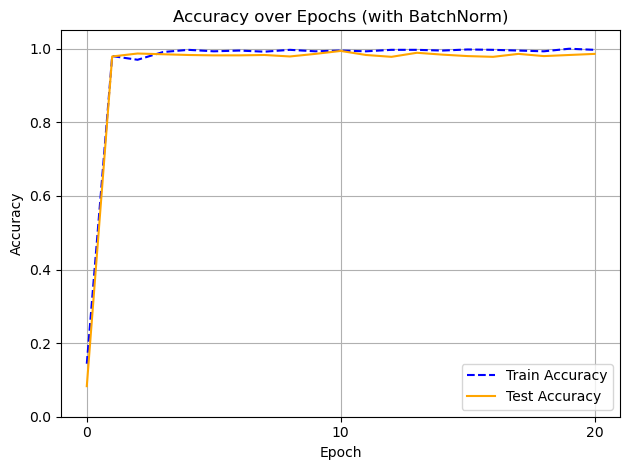

In [29]:
import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(epochs_num + 1))  # 초기 accuracy 포함

# 전체 라인 그리기 (마커 없이)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy', linestyle='--', color='blue')
plt.plot(epochs, test_accuracy_list, label='Test Accuracy', linestyle='-', color='orange')


plt.title('Accuracy over Epochs (with BatchNorm)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.05)
plt.xticks(np.arange(0, epochs_num + 1, 10))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

x = np.arange(2*3*5*5).reshape(2, 3, 5, 5)
x.reshape(-1, )

array([[[[  0,   1,   2,   3,   4],
         [  5,   6,   7,   8,   9],
         [ 10,  11,  12,  13,  14],
         [ 15,  16,  17,  18,  19],
         [ 20,  21,  22,  23,  24]],

        [[ 25,  26,  27,  28,  29],
         [ 30,  31,  32,  33,  34],
         [ 35,  36,  37,  38,  39],
         [ 40,  41,  42,  43,  44],
         [ 45,  46,  47,  48,  49]],

        [[ 50,  51,  52,  53,  54],
         [ 55,  56,  57,  58,  59],
         [ 60,  61,  62,  63,  64],
         [ 65,  66,  67,  68,  69],
         [ 70,  71,  72,  73,  74]]],


       [[[ 75,  76,  77,  78,  79],
         [ 80,  81,  82,  83,  84],
         [ 85,  86,  87,  88,  89],
         [ 90,  91,  92,  93,  94],
         [ 95,  96,  97,  98,  99]],

        [[100, 101, 102, 103, 104],
         [105, 106, 107, 108, 109],
         [110, 111, 112, 113, 114],
         [115, 116, 117, 118, 119],
         [120, 121, 122, 123, 124]],

        [[125, 126, 127, 128, 129],
         [130, 131, 132, 133, 134],
         [135, 1